In [52]:
from torch.utils.data import Dataset
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from torch.utils.data import Dataset
import glob
from PIL import Image
from torch.utils.data import DataLoader

from dataset import datasetloader
from model import CNN


#function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

input_size  = 224*224*3   # images are 224*224 pixels and has 3 channels because of RGB color
output_size = 2      # there are 2 classes---Cat and dog

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 4


# define training and test data directories
#data_dir = '/home/aims/data_cat&dog'
data_dir = './Cat_Dog_DataSet/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')


#create transformers
train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
                                    #transforms.Normalize([0.485, 0.456, 0.406],
                                     #                    [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
                                   # transforms.Normalize([0.485, 0.456, 0.406],
                                    #                     [0.229, 0.224, 0.225])])


#train_data = datasets.ImageFolder(train_dir, transform=train_transform)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#      num_workers=num_workers, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#      num_workers=num_workers)

image_size = (224, 224)
image_row_size = image_size[0] * image_size[1]


mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                                    transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
test_transforms = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
#print("bfore")
train_dataset = datasetloader(train_dir, transform=train_transform)
#print(len(train_dataset))
test_dataset = datasetloader(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
     num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
     num_workers=num_workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracy_list = []

def train(epoch, model):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #print(data[0].shape)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 224*224).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [73]:
train_loader

In [54]:
class datasetloader(Dataset):
    
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory

In [55]:
# Training settings 
n_features = 2 # hyperparameter

model_cnn = CNN(input_size, n_features, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)


Number of parameters: 10610
Train Epoch: 0 [0/60 (0%)]	Loss: 0.694242

Test set: Average loss: 0.6925, Accuracy: 12/24 (50%)



In [56]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [57]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_cat&dog_experiment_1')

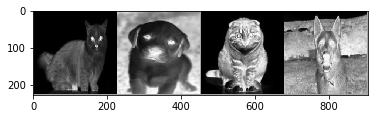

In [58]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_cat&dog_images', img_grid)

In [48]:
!tensorboard --logdir=runs

W0120 15:53:26.739617 139969013769984 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0120 15:53:26.739792 139969013769984 plugin_event_accumulator.py:322] Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
W0120 15:53:26.746675 139969013769984 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0120 15:53:26.746819 139969013769984 plugin_event_accumulator.py:322] Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
W0120 15:53:26.752497 139969013769984 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or m

In [59]:
writer.add_graph(model_cnn, images)
writer.close()

In [60]:
P=torch.zeros(size=(60,3,100,100))
P1=torch.zeros(60)

In [61]:
classes = train_dataset.classes

In [68]:
# helper function
def select_n_random(data, labels, n=60):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(P, P1)

# get the class labels for each image
class_labels = [classes[int(lab)] for lab in labels]

# log embeddings
features = images.view(-1, 100 * 100 * 3)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

In [16]:
# !pip install tensorboard

In [17]:
# !pip uninstall tensorflow

In [63]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [70]:
import numpy as np
running_loss = 0.0
for epoch in range(10):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0:    # every 1000 mini-batches...
            print(running_loss)
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model_cnn, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')


0.6903209686279297
6.8465781807899475
3.4726081490516663
6.803735673427582
3.4647850394248962
6.8231324553489685
3.421537220478058
6.6837998032569885
3.318699836730957
6.577251374721527
3.1482295393943787
5.929019927978516
5.233855903148651
6.932907819747925
3.464771032333374
6.951633930206299
3.469473123550415
6.94074946641922
3.4648003578186035
6.950114727020264
Finished Training


In [20]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        output = model_cnn(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)
